### Visualise the simulation

The simplest and easiest type of analysis you should always do is to look at it with your eyes! Your eyes will tell if you something strange is happening immediately. A numerical analysis may not. Let us look at the simulations on VMD.

Open your vmd, by typing on your terminal:

`% vmd`

When it has finished placing all the windows on the screen. Click on "File" in the VMD main menu window and select "new molecule". The Molecule File Browser window should appear. Click on "browse" then select setup and finally select em.gro (i.e. the file you made that has protein system energy minimized). Click "OK" and then click "Load". It should load up the starting coordinates into the main window. Then click browse in Molecule File Browser window. Select run and then md.xtc. Select "OK" and then hit "load". The trajectory should start loading into the main VMD window. Although things will be moving, you can see that its quite difficult to visualize the individual components. That is one of the problems with simulating such large a complicated
systems. VMD makes it quite easy to look at individual components of a system. For example, let us consider the protein only. On the main menu, left click on Graphics and select "Representations". A new menu will appear (Graphical Representations). In the box entitled "Selected Atoms" type protein and hit enter. Only those atoms that form part of the protein are now selected. Various other selections and drawing methods will help to visualize different aspects of the simulation. More help on the selections is available here.
Now that we are sure the simulation is not doing anything ridiculous, we can start to ask questions about the simulation. The first thing to establish is whether the simulation has equilibrated to some state. So what are some measures of the system
being equilibrated? And what can we use to test the reliability of the simulation?


### Temperature fluctuation

The system temperature as a function of time was calculated in the previous section, with the built-in GROMACS tool `gmx energy`, but we still have not looked at it. It is now time to plot the temperature *vs* time and assess the results.

**Questions**
* Does the temperature fluctuate around an equilibrium  value?\
* Does this value correspond to the temperature that we predefined in the `md.mdp` input file?

The mean temperature is 300.01 K


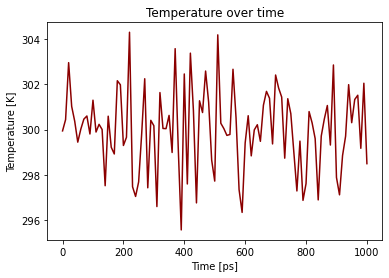

In [64]:
# We declare matplotlib inline to make sure it plots properly
%matplotlib inline
# We need pyplot from matplotlib to plot the dihedrals
from matplotlib import pyplot
import numpy as np

# Read the file that contains the system temperature for each frame
time=np.loadtxt("run/1hsg_temperature.xvg", comments=['#','@'])[:, 0]
temperature=np.loadtxt("run/1hsg_temperature.xvg", comments=['#','@'])[:, 1] 

# Calculate and print the mean temperature
mean_temperature=round(np.mean(temperature), 2)
print(f"The mean temperature is {mean_temperature} K")

# Plot the temperature
pyplot.plot(time, temperature, color='darkred')
pyplot.title("Temperature over time")
pyplot.xlabel("Time [ps]")
pyplot.ylabel("Temperature [K]")
pyplot.show()


### Energy of the system

Another set of properties that is quite useful to examine is the various energetic contributions to the energy. The total
energy should be constant. but the various contributions can change and this can sometimes indicate something
interesting or strange happening in your simulation. Let us look at some energetic properties of the simulation.

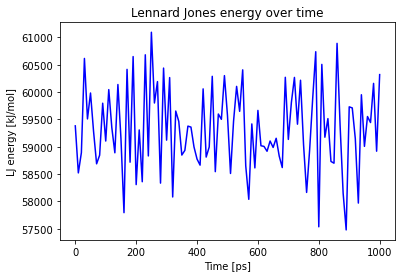

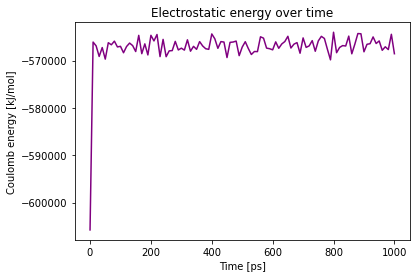

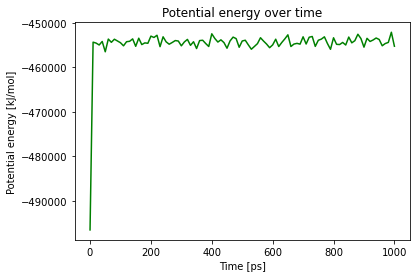

In [65]:
# Read the file that contains the various energetic components for each frame
time=np.loadtxt("run/1hsg_energies.xvg", comments=['#','@'])[:, 0]
lennard_jones=np.loadtxt("run/1hsg_energies.xvg", comments=['#','@'])[:, 1]
coulomb=np.loadtxt("run/1hsg_energies.xvg", comments=['#','@'])[:, 2]
potential=np.loadtxt("run/1hsg_energies.xvg", comments=['#','@'])[:, 3]

# Plot the Lennard-Jones energy
pyplot.plot(time, lennard_jones, color='blue')
pyplot.title("Lennard Jones energy over time")
pyplot.xlabel("Time [ps]")
pyplot.ylabel("LJ energy [kJ/mol]")
pyplot.show()

# Plot the electrostatic energy
pyplot.plot(time, coulomb, color='purple')
pyplot.title("Electrostatic energy over time")
pyplot.xlabel("Time [ps]")
pyplot.ylabel("Coulomb energy [kJ/mol]")
pyplot.show()

# Plot the potential energy
pyplot.plot(time, potential, color='green')
pyplot.title("Potential energy over time")
pyplot.xlabel("Time [ps]")
pyplot.ylabel("Potential energy [kJ/mol]")
pyplot.show()

**Questions**
* Is the total energy stable in this simulation? 
* What is the dominant contribution to the potential energy?

### Analysis of Protein

**Root mean square deviation (RMSD) of 1HSG**

Now that we are happy that the system is OK, let us now consider the root mean square deviation (RMSD). Remember that you have done this before, during the Python tutorial, but here is a reminder! 

The RMSD gives us an idea of how 'stable' our protein is when compared to our starting, static, structure. The lower the RMSD is the, more stable we can say our protein is. 

The RMSD as a function of time, $\rho (t)$, can be defined by the following equation:

\begin{equation}
\\
\rho (t) = \sqrt{\frac{1}{N}\sum^N_{i=1}w_i\big(\mathbf{x}_i(t) - \mathbf{x}^{\text{ref}}_i\big)^2}
\end{equation}

Luckily MDAnalysis has its own built-in function to calculate this and we can import it..



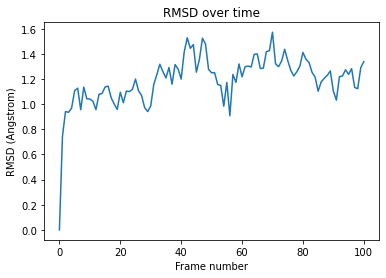

In [66]:
# Import built-in MDAnalysis tools for alignment and RMSD.
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import RMSD as rmsd

# Define the simulation universe and the reference structure (protein structure at first frame)
protein = mda.Universe('./run/md.gro', './run/md.xtc')
protein_ref = mda.Universe('./run/em.gro', './run/md.xtc')
protein_ref.trajectory[0]

# Call the MDAnalysis align function to align the MD simulation universe to the reference (first frame) universe
align_strucs = align.AlignTraj(protein, protein_ref, select="backbone", weights="mass", in_memory=True, verbose=True)

R = align_strucs.run()
rmsd_data = R.rmsd

# Plot the RMSD
pyplot.plot(rmsd_data)
pyplot.title("RMSD over time")
pyplot.xlabel("Frame number")
pyplot.ylabel("RMSD (Angstrom)")
pyplot.show()



**Questions**
* What does this tell you about the stability of the protein? Is it in a state of equilibrium and if so why and at what time?
* Can you think of a situation where this approach might not be a very good indication of stability?

**Root mean square fluctuation (RMSF) of 1HSG**

A similar property that is particularly useful is the root mean square fluctuation (RMSF), which shows how each residue flucuates over its average position.

The RMSF for an atom, $\rho_i$, is given by:

\begin{equation}
\rho_i = \sqrt{\sum^N_{i=1} \big\langle(\mathbf{x}_i - \langle \mathbf{x}_i \rangle )^2 \big\rangle }
\end{equation}

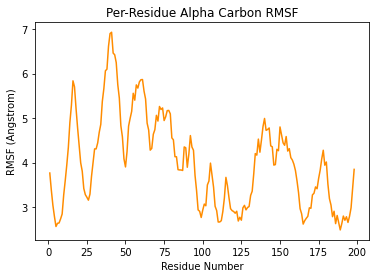

In [76]:
from MDAnalysis.analysis.rms import RMSF as rmsf

# Define again the simulation universe, using however the renumbered .gro file that you had generated earlier
protein = mda.Universe('./run/em_renumbered.gro', './run/md.xtc')

# Reset the trajectory to the first frame
protein.trajectory[0]

# We will need to select the alpha Carbons only
calphas = protein.select_atoms("name CA")
rmsf_calc = rmsf(calphas, verbose=True).run()

#Plot the RMSF
pyplot.plot(calphas.resids, rmsf_calc.rmsf, color='darkorange' )
pyplot.title("Per-Residue Alpha Carbon RMSF")
pyplot.xlabel("Residue Number")
pyplot.ylabel("RMSF (Angstrom)")
pyplot.show()

**Questions**

* Can you identify structural regions alone from this plot and does that fit in with the structure?
* Residues 43-58 form part of the flexible flap that covers the binding site. How does this region behave in the simulation?

This concludes the analysis section, but the possibilities are endless regarding the information that you can collect from this protein simulation. You can enrich this jupyter notebook by performing your own analysis.

### Further Reading

The texts recommended here are the same as those mentioned in the lecture:
* "Molecular Modelling. Principles and Applications". Andrew Leach. Publisher: Prentice Hall. ISBN: 0582382106. This book has rapidly become the defacto introductory text for all aspects of simulation.
* "Computer simulation of liquids". Allen, Michael P., and Dominic J. Tildesley. Oxford university press, 2017.
* "Molecular Dynamics Simulation: Elementary Methods". J.M. Haile. Publisher: Wiley. ISBN: 047118439X. This text provides a more focus but slightly more old-fashioned view of simulation. It has some nice simple examples of how to code (in fortran) some of the algorithms though.
